In [1]:
!pip install catboost
!pip install nb_black

     |████████████████████████████████| 12.7MB 11.2MB/s eta 0:00:01
     |████████████████████████████████| 51kB 5.2MB/s eta 0:00:011
     |████████████████████████████████| 27.7MB 14.9MB/s eta 0:00:01    |█                               | 819kB 16.4MB/s eta 0:00:02


In [ ]:
%load_ext lab_black

In [1]:
import sys

import catboost as cb

wids_path = "/Users/diana/Documents/projects/widsdatathon2022"
sys.path.append(wids_path)

from global_vars import all_feature_columns, response_column
import utils.model_utils as mu
from utils.data_utils import *
from utils.visualize import *
from utils.data_process_utils import *

pd.set_option("display.max_columns", 500)
sns.set_context("talk")

#### read in data
test_df = pd.read_csv(f"{wids_path}/data/test.csv")
print(f"Test dimension: {test_df.shape}")
train_df = pd.read_csv(f"{wids_path}/data/train.csv")
print(f"Train dimension: {train_df.shape}")
sample_solution_df = pd.read_csv(f"{wids_path}/data/sample_solution.csv")
print(f"Sample solution dimension: {sample_solution_df.shape}")
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

Test dimension: (9705, 63)
Train dimension: (75757, 64)
Sample solution dimension: (9705, 2)


In [2]:
(
    train_df.groupby(["facility_type"])["id"].count() / train_df["id"].size * 100
).reset_index(name="train_pct").merge(
    (
        test_df.groupby(["facility_type"])["id"].count() / test_df["id"].size * 100
    ).reset_index(name="test_frac"),
    on="facility_type",
    how="outer",
).sort_values(
    "train_pct", ascending=False
)

,facility_type,train_pct,test_frac
27,Multifamily_Uncategorized,52.080996,22.658423
32,Office_Uncategorized,16.515966,19.773313
6,Education_Other_classroom,5.095239,9.170531
21,Lodging_Hotel,2.769381,3.781556
0,2to4_Unit_Building,2.498779,9.953632
2,Commercial_Other,2.302097,3.348789
1,5plus_Unit_Building,1.680373,7.058217
56,Warehouse_Nonrefrigerated,1.656613,1.133436
50,Retail_Uncategorized,1.491611,2.318393
5,Education_College_or_university,1.393931,2.081401


In [28]:
feature_dict = {
    "base_cat": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": False,
        "backfill_dict": {},
    },
    "base_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": [],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_onehot": {
        "cols_to_reduce": [],
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
    "log_temp_pca_onehot_impute": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {
            "energy_star_rating": ["state_factor", "building_class", "facility_type"]
        },
    },
    "log_temp_pca_cat": {
        "cols_to_reduce": temp_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": False,
        "backfill_dict": {},
    },
    "log_temp_precip_pca_onehot": {
        "cols_to_reduce": temp_col_list + inch_col_list,
        "log10_transform_cols": ["floor_area"],
        "if_one_hot": True,
        "backfill_dict": {},
    },
}

Fitting PCA with 9 components


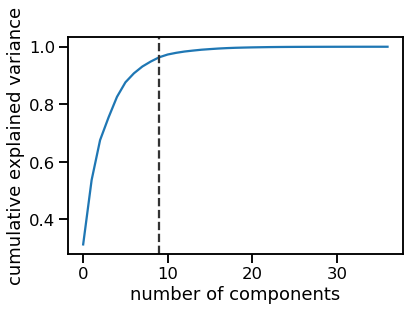

In [29]:
config_name = "log_temp_pca_onehot_impute"
cols_to_reduce = feature_dict[config_name]["cols_to_reduce"]
log10_transform_cols = feature_dict[config_name]["log10_transform_cols"]
backfill_dict = feature_dict[config_name]["backfill_dict"]
if_scale = False
if_one_hot = feature_dict[config_name]["if_one_hot"]

# PCA on all of the environmental factor cols!
model = cb.CatBoostRegressor(loss_function="RMSE")

train_filter_df, test_filter_df, pca_cols = process_data(
    train_df.drop_duplicates(),
    test_df.drop_duplicates(),
    cols_to_reduce,
    log10_transform_cols,
    0,
    backfill_dict,
)

In [30]:
train_filter_df.filter(like='energy_star_rating').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75757 entries, 0 to 75756
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   energy_star_rating             49048 non-null  float64
 1   backfilled_energy_star_rating  69377 non-null  float64
dtypes: float64(2)
memory usage: 1.7 MB


In [7]:
# features_columns = (
#     list(set(all_feature_columns) - set(cols_to_reduce) - set(log10_transform_cols))
#     + pca_cols
#     + [f"log10_{col}" for col in log10_transform_cols]
# )
features_columns = (
    list(set(all_feature_columns) - set(cols_to_reduce) - set(log10_transform_cols))
    + pca_cols
    + [f"log10_{col}" for col in log10_transform_cols]
)
if backfill_dict:
    backfill_cols = list(backfill_dict.keys())
    features_columns = list(set(features_columns) - set(backfill_cols)) + [
        f"backfilled_{col}" for col in backfill_cols
    ]
print(config_name, features_columns, if_one_hot)

log_temp_pca_onehot_impute ['days_above_100f', 'days_below_20f', 'cooling_degree_days', 'temp_pca3', 'days_above_80f', 'snowfall_inches', 'temp_pca4', 'year_built', 'log10_floor_area', 'temp_pca8', 'heating_degree_days', 'precipitation_inches', 'days_below_30f', 'days_above_90f', 'direction_max_wind_speed', 'state_factor', 'temp_pca5', 'building_class', 'days_below_0f', 'facility_type', 'snowdepth_inches', 'days_with_fog', 'days_above_110f', 'direction_peak_wind_speed', 'elevation', 'temp_pca1', 'temp_pca7', 'temp_pca9', 'max_wind_speed', 'temp_pca6', 'temp_pca2', 'days_below_10f', 'backfilled_energy_star_rating'] True


In [8]:
## Run LOY model
catboost_rmse = mu.run_leave_year_out(
    model_df=train_filter_df,
    ml_model=model,
    features_columns=features_columns,
    if_scale_data=if_scale,
    if_one_hot=if_one_hot,
    model_type="catboost",
)
print(f"Average RMSE:\n{catboost_rmse.mean()}")
display(catboost_rmse)

## predict on test data
train_filter_x_df, train_filter_y_df = mu.split_model_feature_response(
    train_filter_df, features_columns
)
test_filter_x_df = mu.split_model_feature_response(
    test_filter_df, features_columns, if_with_response=False
)
processed_train_x_df, processed_test_x_df = mu.process_train_test_data(
    train_filter_x_df, test_filter_x_df, if_scale, if_one_hot,
)

train_predict, test_predict = mu.run_catboost_model(
    model, processed_train_x_df, train_filter_y_df, processed_test_x_df
)
training_rmse = mu.calculate_rmse(train_filter_y_df, train_predict)
print(f"Whole data train RMSE: {training_rmse}")

## output save result
catboost_rmse.loc[catboost_rmse.shape[0], :] = [0, training_rmse, np.nan]
catboost_rmse['method'] = catboost_rmse['left_out_year'].apply(lambda x: 'loyo' if x>0 else 'whole train')
display(catboost_rmse)
catboost_rmse.to_csv(f"{wids_path}/validation_result/{config_name}.csv", index=False)

test_prediction_result = test_df[["id"]]
test_prediction_result["site_eui"] = test_predict
test_prediction_result.to_csv(
    f"{wids_path}/prediction_result/{config_name}.csv", index=False
)

Running catboost
Modeling 1...
Columns to be dummied: ['building_class', 'state_factor', 'facility_type']
Learning rate set to 0.080758
0:	learn: 56.3026653	total: 72ms	remaining: 1m 11s
1:	learn: 55.3389844	total: 89.5ms	remaining: 44.7s
2:	learn: 54.4959995	total: 102ms	remaining: 33.9s
3:	learn: 53.7406822	total: 116ms	remaining: 28.9s
4:	learn: 53.0888950	total: 131ms	remaining: 26.1s
5:	learn: 52.4821169	total: 150ms	remaining: 24.9s
6:	learn: 51.9823075	total: 174ms	remaining: 24.7s
7:	learn: 51.5292978	total: 192ms	remaining: 23.8s
8:	learn: 51.1215115	total: 208ms	remaining: 22.9s
9:	learn: 50.7500496	total: 224ms	remaining: 22.2s
10:	learn: 50.3862380	total: 273ms	remaining: 24.6s
11:	learn: 50.0862612	total: 336ms	remaining: 27.6s
12:	learn: 49.7833236	total: 350ms	remaining: 26.6s
13:	learn: 49.4866412	total: 363ms	remaining: 25.5s
14:	learn: 49.2285005	total: 378ms	remaining: 24.8s
15:	learn: 48.9689021	total: 405ms	remaining: 24.9s
16:	learn: 48.7184459	total: 426ms	remain

172:	learn: 41.3751059	total: 2.63s	remaining: 12.6s
173:	learn: 41.3545457	total: 2.65s	remaining: 12.6s
174:	learn: 41.3355727	total: 2.67s	remaining: 12.6s
175:	learn: 41.3125240	total: 2.68s	remaining: 12.5s
176:	learn: 41.3004232	total: 2.69s	remaining: 12.5s
177:	learn: 41.2832726	total: 2.7s	remaining: 12.5s
178:	learn: 41.2727371	total: 2.71s	remaining: 12.4s
179:	learn: 41.2628358	total: 2.72s	remaining: 12.4s
180:	learn: 41.2466264	total: 2.73s	remaining: 12.3s
181:	learn: 41.2342560	total: 2.74s	remaining: 12.3s
182:	learn: 41.2167699	total: 2.75s	remaining: 12.3s
183:	learn: 41.2006681	total: 2.76s	remaining: 12.2s
184:	learn: 41.1772276	total: 2.77s	remaining: 12.2s
185:	learn: 41.1569319	total: 2.78s	remaining: 12.2s
186:	learn: 41.1509623	total: 2.79s	remaining: 12.1s
187:	learn: 41.1278522	total: 2.8s	remaining: 12.1s
188:	learn: 41.1081372	total: 2.81s	remaining: 12.1s
189:	learn: 41.0888960	total: 2.82s	remaining: 12s
190:	learn: 41.0768222	total: 2.83s	remaining: 12s

333:	learn: 39.3312784	total: 4.48s	remaining: 8.94s
334:	learn: 39.3199506	total: 4.5s	remaining: 8.93s
335:	learn: 39.3000051	total: 4.51s	remaining: 8.92s
336:	learn: 39.2856068	total: 4.53s	remaining: 8.91s
337:	learn: 39.2767571	total: 4.54s	remaining: 8.89s
338:	learn: 39.2396569	total: 4.55s	remaining: 8.88s
339:	learn: 39.2276658	total: 4.57s	remaining: 8.87s
340:	learn: 39.2187902	total: 4.58s	remaining: 8.86s
341:	learn: 39.2077414	total: 4.6s	remaining: 8.85s
342:	learn: 39.2070052	total: 4.61s	remaining: 8.83s
343:	learn: 39.1987666	total: 4.62s	remaining: 8.81s
344:	learn: 39.1930749	total: 4.63s	remaining: 8.8s
345:	learn: 39.1863173	total: 4.65s	remaining: 8.78s
346:	learn: 39.1803746	total: 4.66s	remaining: 8.77s
347:	learn: 39.1708217	total: 4.67s	remaining: 8.75s
348:	learn: 39.1599061	total: 4.69s	remaining: 8.75s
349:	learn: 39.1455525	total: 4.71s	remaining: 8.74s
350:	learn: 39.1388201	total: 4.72s	remaining: 8.72s
351:	learn: 39.1325010	total: 4.73s	remaining: 8.

500:	learn: 37.8390964	total: 6.76s	remaining: 6.73s
501:	learn: 37.8348169	total: 6.78s	remaining: 6.72s
502:	learn: 37.8183211	total: 6.79s	remaining: 6.71s
503:	learn: 37.8092393	total: 6.81s	remaining: 6.7s
504:	learn: 37.8013734	total: 6.82s	remaining: 6.68s
505:	learn: 37.7951062	total: 6.83s	remaining: 6.67s
506:	learn: 37.7884004	total: 6.84s	remaining: 6.65s
507:	learn: 37.7807641	total: 6.86s	remaining: 6.64s
508:	learn: 37.7719632	total: 6.87s	remaining: 6.63s
509:	learn: 37.7665172	total: 6.88s	remaining: 6.61s
510:	learn: 37.7587877	total: 6.89s	remaining: 6.6s
511:	learn: 37.7496488	total: 6.91s	remaining: 6.58s
512:	learn: 37.7410456	total: 6.92s	remaining: 6.57s
513:	learn: 37.7315835	total: 6.93s	remaining: 6.56s
514:	learn: 37.7261013	total: 6.95s	remaining: 6.54s
515:	learn: 37.7217226	total: 6.96s	remaining: 6.53s
516:	learn: 37.7130939	total: 6.97s	remaining: 6.51s
517:	learn: 37.7087024	total: 6.99s	remaining: 6.5s
518:	learn: 37.7022086	total: 7s	remaining: 6.49s

669:	learn: 36.7585041	total: 9.28s	remaining: 4.57s
670:	learn: 36.7554294	total: 9.29s	remaining: 4.56s
671:	learn: 36.7528138	total: 9.31s	remaining: 4.54s
672:	learn: 36.7438429	total: 9.32s	remaining: 4.53s
673:	learn: 36.7409292	total: 9.33s	remaining: 4.51s
674:	learn: 36.7346970	total: 9.34s	remaining: 4.5s
675:	learn: 36.7300904	total: 9.35s	remaining: 4.48s
676:	learn: 36.7210931	total: 9.37s	remaining: 4.47s
677:	learn: 36.7169755	total: 9.38s	remaining: 4.46s
678:	learn: 36.7043066	total: 9.39s	remaining: 4.44s
679:	learn: 36.6990416	total: 9.4s	remaining: 4.42s
680:	learn: 36.6935634	total: 9.42s	remaining: 4.41s
681:	learn: 36.6888737	total: 9.43s	remaining: 4.4s
682:	learn: 36.6811493	total: 9.44s	remaining: 4.38s
683:	learn: 36.6722527	total: 9.46s	remaining: 4.37s
684:	learn: 36.6691239	total: 9.47s	remaining: 4.35s
685:	learn: 36.6613797	total: 9.48s	remaining: 4.34s
686:	learn: 36.6569917	total: 9.5s	remaining: 4.33s
687:	learn: 36.6546972	total: 9.51s	remaining: 4.3

832:	learn: 35.8766329	total: 11.6s	remaining: 2.32s
833:	learn: 35.8660647	total: 11.6s	remaining: 2.31s
834:	learn: 35.8648133	total: 11.6s	remaining: 2.3s
835:	learn: 35.8578533	total: 11.6s	remaining: 2.28s
836:	learn: 35.8521498	total: 11.7s	remaining: 2.27s
837:	learn: 35.8499934	total: 11.7s	remaining: 2.26s
838:	learn: 35.8406897	total: 11.7s	remaining: 2.24s
839:	learn: 35.8390741	total: 11.7s	remaining: 2.23s
840:	learn: 35.8328490	total: 11.7s	remaining: 2.22s
841:	learn: 35.8292586	total: 11.7s	remaining: 2.2s
842:	learn: 35.8269819	total: 11.8s	remaining: 2.19s
843:	learn: 35.8185418	total: 11.8s	remaining: 2.17s
844:	learn: 35.8165229	total: 11.8s	remaining: 2.16s
845:	learn: 35.8155210	total: 11.8s	remaining: 2.15s
846:	learn: 35.8144115	total: 11.8s	remaining: 2.13s
847:	learn: 35.8086673	total: 11.8s	remaining: 2.12s
848:	learn: 35.8054120	total: 11.8s	remaining: 2.11s
849:	learn: 35.8002288	total: 11.9s	remaining: 2.09s
850:	learn: 35.7963979	total: 11.9s	remaining: 2

994:	learn: 35.1747560	total: 13.9s	remaining: 69.8ms
995:	learn: 35.1691483	total: 13.9s	remaining: 55.8ms
996:	learn: 35.1610243	total: 13.9s	remaining: 41.9ms
997:	learn: 35.1606399	total: 13.9s	remaining: 27.9ms
998:	learn: 35.1553306	total: 13.9s	remaining: 13.9ms
999:	learn: 35.1490955	total: 13.9s	remaining: 0us
Modeling 2...
Columns to be dummied: ['building_class', 'state_factor', 'facility_type']
Learning rate set to 0.079504
0:	learn: 57.6887578	total: 11.3ms	remaining: 11.3s
1:	learn: 56.6923090	total: 22.7ms	remaining: 11.3s
2:	learn: 55.7638743	total: 32.7ms	remaining: 10.9s
3:	learn: 54.9529508	total: 42.9ms	remaining: 10.7s
4:	learn: 54.2392504	total: 53.2ms	remaining: 10.6s
5:	learn: 53.6505890	total: 62.6ms	remaining: 10.4s
6:	learn: 53.0887025	total: 72.7ms	remaining: 10.3s
7:	learn: 52.5567493	total: 83.7ms	remaining: 10.4s
8:	learn: 52.1053281	total: 98.4ms	remaining: 10.8s
9:	learn: 51.6995724	total: 112ms	remaining: 11s
10:	learn: 51.3332770	total: 122ms	remainin

156:	learn: 42.0139258	total: 1.82s	remaining: 9.79s
157:	learn: 41.9807938	total: 1.84s	remaining: 9.79s
158:	learn: 41.9627498	total: 1.85s	remaining: 9.8s
159:	learn: 41.9435697	total: 1.86s	remaining: 9.79s
160:	learn: 41.9237005	total: 1.88s	remaining: 9.79s
161:	learn: 41.8880390	total: 1.89s	remaining: 9.77s
162:	learn: 41.8649862	total: 1.9s	remaining: 9.77s
163:	learn: 41.8525693	total: 1.91s	remaining: 9.75s
164:	learn: 41.8395268	total: 1.92s	remaining: 9.73s
165:	learn: 41.8163111	total: 1.93s	remaining: 9.72s
166:	learn: 41.7886701	total: 1.95s	remaining: 9.7s
167:	learn: 41.7746718	total: 1.96s	remaining: 9.69s
168:	learn: 41.7556707	total: 1.97s	remaining: 9.68s
169:	learn: 41.7443143	total: 1.98s	remaining: 9.66s
170:	learn: 41.7255701	total: 1.99s	remaining: 9.66s
171:	learn: 41.7126978	total: 2s	remaining: 9.64s
172:	learn: 41.6967271	total: 2.02s	remaining: 9.65s
173:	learn: 41.6873844	total: 2.08s	remaining: 9.85s
174:	learn: 41.6624061	total: 2.09s	remaining: 9.86s

312:	learn: 39.6505666	total: 3.74s	remaining: 8.22s
313:	learn: 39.6371388	total: 3.76s	remaining: 8.21s
314:	learn: 39.6277879	total: 3.77s	remaining: 8.21s
315:	learn: 39.6211076	total: 3.79s	remaining: 8.2s
316:	learn: 39.5989829	total: 3.8s	remaining: 8.19s
317:	learn: 39.5905497	total: 3.81s	remaining: 8.18s
318:	learn: 39.5854099	total: 3.82s	remaining: 8.16s
319:	learn: 39.5732923	total: 3.83s	remaining: 8.15s
320:	learn: 39.5592925	total: 3.84s	remaining: 8.13s
321:	learn: 39.5474755	total: 3.85s	remaining: 8.12s
322:	learn: 39.5295720	total: 3.87s	remaining: 8.1s
323:	learn: 39.5227944	total: 3.88s	remaining: 8.09s
324:	learn: 39.5134598	total: 3.88s	remaining: 8.07s
325:	learn: 39.5037469	total: 3.9s	remaining: 8.06s
326:	learn: 39.4799722	total: 3.91s	remaining: 8.05s
327:	learn: 39.4701275	total: 3.93s	remaining: 8.04s
328:	learn: 39.4620926	total: 3.94s	remaining: 8.03s
329:	learn: 39.4524258	total: 3.95s	remaining: 8.02s
330:	learn: 39.4475433	total: 3.96s	remaining: 8.0

477:	learn: 38.1120683	total: 5.81s	remaining: 6.34s
478:	learn: 38.1026005	total: 5.83s	remaining: 6.34s
479:	learn: 38.0916339	total: 5.84s	remaining: 6.33s
480:	learn: 38.0749875	total: 5.85s	remaining: 6.31s
481:	learn: 38.0633021	total: 5.86s	remaining: 6.3s
482:	learn: 38.0554088	total: 5.87s	remaining: 6.29s
483:	learn: 38.0450721	total: 5.89s	remaining: 6.28s
484:	learn: 38.0391258	total: 5.9s	remaining: 6.26s
485:	learn: 38.0322317	total: 5.91s	remaining: 6.25s
486:	learn: 38.0284655	total: 5.92s	remaining: 6.24s
487:	learn: 38.0207708	total: 5.93s	remaining: 6.22s
488:	learn: 38.0173683	total: 5.94s	remaining: 6.21s
489:	learn: 38.0106414	total: 5.95s	remaining: 6.2s
490:	learn: 38.0021455	total: 5.96s	remaining: 6.18s
491:	learn: 37.9925685	total: 5.97s	remaining: 6.17s
492:	learn: 37.9846725	total: 5.98s	remaining: 6.15s
493:	learn: 37.9800682	total: 5.99s	remaining: 6.14s
494:	learn: 37.9701882	total: 6.01s	remaining: 6.13s
495:	learn: 37.9634021	total: 6.03s	remaining: 6.

640:	learn: 36.9749222	total: 7.87s	remaining: 4.4s
641:	learn: 36.9641510	total: 7.88s	remaining: 4.4s
642:	learn: 36.9603879	total: 7.89s	remaining: 4.38s
643:	learn: 36.9489847	total: 7.91s	remaining: 4.37s
644:	learn: 36.9448339	total: 7.92s	remaining: 4.36s
645:	learn: 36.9424578	total: 7.94s	remaining: 4.35s
646:	learn: 36.9393558	total: 7.95s	remaining: 4.34s
647:	learn: 36.9329084	total: 7.96s	remaining: 4.32s
648:	learn: 36.9298934	total: 7.97s	remaining: 4.31s
649:	learn: 36.9284831	total: 7.98s	remaining: 4.29s
650:	learn: 36.9204743	total: 7.99s	remaining: 4.28s
651:	learn: 36.9159231	total: 8s	remaining: 4.27s
652:	learn: 36.9132217	total: 8.01s	remaining: 4.26s
653:	learn: 36.8974188	total: 8.03s	remaining: 4.25s
654:	learn: 36.8957173	total: 8.04s	remaining: 4.23s
655:	learn: 36.8897614	total: 8.05s	remaining: 4.22s
656:	learn: 36.8821944	total: 8.06s	remaining: 4.21s
657:	learn: 36.8728979	total: 8.07s	remaining: 4.2s
658:	learn: 36.8678172	total: 8.08s	remaining: 4.18s

804:	learn: 36.0312752	total: 9.73s	remaining: 2.36s
805:	learn: 36.0268252	total: 9.74s	remaining: 2.35s
806:	learn: 36.0238186	total: 9.75s	remaining: 2.33s
807:	learn: 36.0161557	total: 9.76s	remaining: 2.32s
808:	learn: 36.0115315	total: 9.77s	remaining: 2.31s
809:	learn: 36.0066647	total: 9.78s	remaining: 2.29s
810:	learn: 36.0046471	total: 9.79s	remaining: 2.28s
811:	learn: 36.0027238	total: 9.8s	remaining: 2.27s
812:	learn: 35.9968735	total: 9.81s	remaining: 2.26s
813:	learn: 35.9923002	total: 9.82s	remaining: 2.24s
814:	learn: 35.9867430	total: 9.83s	remaining: 2.23s
815:	learn: 35.9858635	total: 9.84s	remaining: 2.22s
816:	learn: 35.9853818	total: 9.85s	remaining: 2.21s
817:	learn: 35.9794135	total: 9.86s	remaining: 2.19s
818:	learn: 35.9781839	total: 9.87s	remaining: 2.18s
819:	learn: 35.9752730	total: 9.88s	remaining: 2.17s
820:	learn: 35.9671924	total: 9.88s	remaining: 2.15s
821:	learn: 35.9633543	total: 9.89s	remaining: 2.14s
822:	learn: 35.9612423	total: 9.91s	remaining: 

975:	learn: 35.2019567	total: 11.8s	remaining: 290ms
976:	learn: 35.1977539	total: 11.8s	remaining: 278ms
977:	learn: 35.1910936	total: 11.8s	remaining: 266ms
978:	learn: 35.1857097	total: 11.8s	remaining: 254ms
979:	learn: 35.1828298	total: 11.8s	remaining: 242ms
980:	learn: 35.1800435	total: 11.9s	remaining: 230ms
981:	learn: 35.1744996	total: 11.9s	remaining: 217ms
982:	learn: 35.1735584	total: 11.9s	remaining: 205ms
983:	learn: 35.1710224	total: 11.9s	remaining: 193ms
984:	learn: 35.1672858	total: 11.9s	remaining: 181ms
985:	learn: 35.1596939	total: 11.9s	remaining: 169ms
986:	learn: 35.1560805	total: 11.9s	remaining: 157ms
987:	learn: 35.1543129	total: 11.9s	remaining: 145ms
988:	learn: 35.1508485	total: 11.9s	remaining: 133ms
989:	learn: 35.1474239	total: 12s	remaining: 121ms
990:	learn: 35.1436464	total: 12s	remaining: 109ms
991:	learn: 35.1388737	total: 12s	remaining: 96.6ms
992:	learn: 35.1355389	total: 12s	remaining: 84.6ms
993:	learn: 35.1330214	total: 12s	remaining: 72.5ms


143:	learn: 41.2456958	total: 1.63s	remaining: 9.69s
144:	learn: 41.2285062	total: 1.64s	remaining: 9.7s
145:	learn: 41.1992091	total: 1.66s	remaining: 9.68s
146:	learn: 41.1820705	total: 1.66s	remaining: 9.66s
147:	learn: 41.1651731	total: 1.67s	remaining: 9.64s
148:	learn: 41.1416641	total: 1.69s	remaining: 9.63s
149:	learn: 41.1249928	total: 1.7s	remaining: 9.61s
150:	learn: 41.0942891	total: 1.71s	remaining: 9.59s
151:	learn: 41.0726456	total: 1.72s	remaining: 9.57s
152:	learn: 41.0572923	total: 1.73s	remaining: 9.55s
153:	learn: 41.0394284	total: 1.74s	remaining: 9.54s
154:	learn: 41.0086075	total: 1.75s	remaining: 9.53s
155:	learn: 40.9915184	total: 1.76s	remaining: 9.51s
156:	learn: 40.9753284	total: 1.77s	remaining: 9.5s
157:	learn: 40.9611484	total: 1.78s	remaining: 9.48s
158:	learn: 40.9278812	total: 1.79s	remaining: 9.47s
159:	learn: 40.8988437	total: 1.8s	remaining: 9.46s
160:	learn: 40.8739023	total: 1.81s	remaining: 9.45s
161:	learn: 40.8513352	total: 1.83s	remaining: 9.4

310:	learn: 38.7254704	total: 3.67s	remaining: 8.13s
311:	learn: 38.7202412	total: 3.71s	remaining: 8.18s
312:	learn: 38.7152782	total: 3.74s	remaining: 8.22s
313:	learn: 38.6963230	total: 3.76s	remaining: 8.21s
314:	learn: 38.6887029	total: 3.77s	remaining: 8.2s
315:	learn: 38.6716169	total: 3.78s	remaining: 8.18s
316:	learn: 38.6646206	total: 3.79s	remaining: 8.16s
317:	learn: 38.6631125	total: 3.8s	remaining: 8.14s
318:	learn: 38.6507909	total: 3.81s	remaining: 8.14s
319:	learn: 38.6498794	total: 3.82s	remaining: 8.12s
320:	learn: 38.6375668	total: 3.83s	remaining: 8.1s
321:	learn: 38.6246056	total: 3.84s	remaining: 8.09s
322:	learn: 38.6184739	total: 3.85s	remaining: 8.07s
323:	learn: 38.6110175	total: 3.86s	remaining: 8.06s
324:	learn: 38.5997322	total: 3.88s	remaining: 8.05s
325:	learn: 38.5888775	total: 3.89s	remaining: 8.04s
326:	learn: 38.5733905	total: 3.9s	remaining: 8.03s
327:	learn: 38.5573189	total: 3.91s	remaining: 8.02s
328:	learn: 38.5564503	total: 3.92s	remaining: 8s


469:	learn: 37.2224446	total: 5.49s	remaining: 6.19s
470:	learn: 37.2130672	total: 5.51s	remaining: 6.18s
471:	learn: 37.2056042	total: 5.52s	remaining: 6.18s
472:	learn: 37.1956329	total: 5.54s	remaining: 6.17s
473:	learn: 37.1867552	total: 5.55s	remaining: 6.16s
474:	learn: 37.1834423	total: 5.56s	remaining: 6.15s
475:	learn: 37.1799043	total: 5.57s	remaining: 6.14s
476:	learn: 37.1715890	total: 5.59s	remaining: 6.12s
477:	learn: 37.1614948	total: 5.6s	remaining: 6.11s
478:	learn: 37.1542899	total: 5.61s	remaining: 6.1s
479:	learn: 37.1434109	total: 5.62s	remaining: 6.09s
480:	learn: 37.1366006	total: 5.64s	remaining: 6.08s
481:	learn: 37.1273068	total: 5.65s	remaining: 6.07s
482:	learn: 37.1240038	total: 5.66s	remaining: 6.06s
483:	learn: 37.1198524	total: 5.67s	remaining: 6.04s
484:	learn: 37.1170578	total: 5.68s	remaining: 6.03s
485:	learn: 37.1058898	total: 5.7s	remaining: 6.02s
486:	learn: 37.0930667	total: 5.71s	remaining: 6.02s
487:	learn: 37.0837643	total: 5.72s	remaining: 6.

628:	learn: 36.1165382	total: 7.31s	remaining: 4.31s
629:	learn: 36.1114536	total: 7.33s	remaining: 4.3s
630:	learn: 36.1097813	total: 7.34s	remaining: 4.29s
631:	learn: 36.1025197	total: 7.35s	remaining: 4.28s
632:	learn: 36.0993488	total: 7.36s	remaining: 4.26s
633:	learn: 36.0902884	total: 7.37s	remaining: 4.25s
634:	learn: 36.0890703	total: 7.38s	remaining: 4.24s
635:	learn: 36.0848959	total: 7.38s	remaining: 4.23s
636:	learn: 36.0771899	total: 7.39s	remaining: 4.21s
637:	learn: 36.0610925	total: 7.4s	remaining: 4.2s
638:	learn: 36.0541392	total: 7.41s	remaining: 4.19s
639:	learn: 36.0503582	total: 7.42s	remaining: 4.17s
640:	learn: 36.0448482	total: 7.43s	remaining: 4.16s
641:	learn: 36.0412756	total: 7.44s	remaining: 4.15s
642:	learn: 36.0360883	total: 7.45s	remaining: 4.14s
643:	learn: 36.0278148	total: 7.46s	remaining: 4.12s
644:	learn: 36.0253337	total: 7.47s	remaining: 4.11s
645:	learn: 36.0218991	total: 7.48s	remaining: 4.1s
646:	learn: 36.0135086	total: 7.49s	remaining: 4.0

791:	learn: 35.2458754	total: 9.12s	remaining: 2.4s
792:	learn: 35.2409045	total: 9.14s	remaining: 2.39s
793:	learn: 35.2366074	total: 9.16s	remaining: 2.38s
794:	learn: 35.2342918	total: 9.17s	remaining: 2.37s
795:	learn: 35.2278411	total: 9.18s	remaining: 2.35s
796:	learn: 35.2245981	total: 9.2s	remaining: 2.34s
797:	learn: 35.2188823	total: 9.21s	remaining: 2.33s
798:	learn: 35.2145154	total: 9.22s	remaining: 2.32s
799:	learn: 35.2052678	total: 9.24s	remaining: 2.31s
800:	learn: 35.2006445	total: 9.25s	remaining: 2.3s
801:	learn: 35.1966789	total: 9.26s	remaining: 2.29s
802:	learn: 35.1931674	total: 9.27s	remaining: 2.27s
803:	learn: 35.1911315	total: 9.28s	remaining: 2.26s
804:	learn: 35.1823181	total: 9.3s	remaining: 2.25s
805:	learn: 35.1765684	total: 9.31s	remaining: 2.24s
806:	learn: 35.1692549	total: 9.32s	remaining: 2.23s
807:	learn: 35.1670194	total: 9.34s	remaining: 2.22s
808:	learn: 35.1617059	total: 9.36s	remaining: 2.21s
809:	learn: 35.1504052	total: 9.37s	remaining: 2.2

955:	learn: 34.4689742	total: 11.2s	remaining: 514ms
956:	learn: 34.4674443	total: 11.2s	remaining: 503ms
957:	learn: 34.4613754	total: 11.2s	remaining: 491ms
958:	learn: 34.4554996	total: 11.2s	remaining: 479ms
959:	learn: 34.4515545	total: 11.2s	remaining: 468ms
960:	learn: 34.4475429	total: 11.2s	remaining: 456ms
961:	learn: 34.4443740	total: 11.3s	remaining: 445ms
962:	learn: 34.4399237	total: 11.3s	remaining: 433ms
963:	learn: 34.4375855	total: 11.3s	remaining: 421ms
964:	learn: 34.4349622	total: 11.3s	remaining: 409ms
965:	learn: 34.4295732	total: 11.3s	remaining: 398ms
966:	learn: 34.4261541	total: 11.3s	remaining: 386ms
967:	learn: 34.4200882	total: 11.3s	remaining: 375ms
968:	learn: 34.4130946	total: 11.3s	remaining: 363ms
969:	learn: 34.4106396	total: 11.4s	remaining: 351ms
970:	learn: 34.4018980	total: 11.4s	remaining: 340ms
971:	learn: 34.3936730	total: 11.4s	remaining: 328ms
972:	learn: 34.3886064	total: 11.4s	remaining: 316ms
973:	learn: 34.3872373	total: 11.4s	remaining:

117:	learn: 43.2024315	total: 1.22s	remaining: 9.1s
118:	learn: 43.1684788	total: 1.23s	remaining: 9.13s
119:	learn: 43.1346108	total: 1.24s	remaining: 9.13s
120:	learn: 43.1085219	total: 1.26s	remaining: 9.12s
121:	learn: 43.0807668	total: 1.26s	remaining: 9.1s
122:	learn: 43.0519018	total: 1.27s	remaining: 9.08s
123:	learn: 43.0283774	total: 1.28s	remaining: 9.06s
124:	learn: 43.0125958	total: 1.29s	remaining: 9.04s
125:	learn: 42.9738494	total: 1.3s	remaining: 9.02s
126:	learn: 42.9522716	total: 1.31s	remaining: 8.99s
127:	learn: 42.9301419	total: 1.32s	remaining: 8.99s
128:	learn: 42.9081773	total: 1.33s	remaining: 8.97s
129:	learn: 42.8869556	total: 1.34s	remaining: 8.95s
130:	learn: 42.8588759	total: 1.35s	remaining: 8.95s
131:	learn: 42.8454517	total: 1.36s	remaining: 8.93s
132:	learn: 42.8215565	total: 1.37s	remaining: 8.92s
133:	learn: 42.8057542	total: 1.38s	remaining: 8.91s
134:	learn: 42.7962936	total: 1.39s	remaining: 8.89s
135:	learn: 42.7764783	total: 1.4s	remaining: 8.8

275:	learn: 40.5588858	total: 2.84s	remaining: 7.45s
276:	learn: 40.5511212	total: 2.85s	remaining: 7.45s
277:	learn: 40.5451631	total: 2.86s	remaining: 7.44s
278:	learn: 40.5309068	total: 2.88s	remaining: 7.43s
279:	learn: 40.5197688	total: 2.88s	remaining: 7.42s
280:	learn: 40.5062954	total: 2.89s	remaining: 7.4s
281:	learn: 40.4902597	total: 2.9s	remaining: 7.39s
282:	learn: 40.4765166	total: 2.91s	remaining: 7.38s
283:	learn: 40.4613009	total: 2.92s	remaining: 7.37s
284:	learn: 40.4541826	total: 2.93s	remaining: 7.36s
285:	learn: 40.4426757	total: 2.94s	remaining: 7.35s
286:	learn: 40.4413886	total: 2.95s	remaining: 7.33s
287:	learn: 40.4339941	total: 2.96s	remaining: 7.33s
288:	learn: 40.4213954	total: 2.97s	remaining: 7.32s
289:	learn: 40.4101536	total: 2.99s	remaining: 7.32s
290:	learn: 40.3975035	total: 3s	remaining: 7.31s
291:	learn: 40.3915814	total: 3.01s	remaining: 7.3s
292:	learn: 40.3903489	total: 3.02s	remaining: 7.29s
293:	learn: 40.3892025	total: 3.03s	remaining: 7.28s

435:	learn: 38.9684785	total: 4.67s	remaining: 6.05s
436:	learn: 38.9555970	total: 4.69s	remaining: 6.04s
437:	learn: 38.9488691	total: 4.71s	remaining: 6.04s
438:	learn: 38.9337180	total: 4.72s	remaining: 6.03s
439:	learn: 38.9284607	total: 4.73s	remaining: 6.02s
440:	learn: 38.9220544	total: 4.74s	remaining: 6.01s
441:	learn: 38.9169883	total: 4.75s	remaining: 6s
442:	learn: 38.9075841	total: 4.76s	remaining: 5.99s
443:	learn: 38.9009908	total: 4.78s	remaining: 5.98s
444:	learn: 38.8925778	total: 4.79s	remaining: 5.97s
445:	learn: 38.8748803	total: 4.8s	remaining: 5.96s
446:	learn: 38.8707722	total: 4.81s	remaining: 5.95s
447:	learn: 38.8601891	total: 4.82s	remaining: 5.94s
448:	learn: 38.8570391	total: 4.83s	remaining: 5.93s
449:	learn: 38.8511990	total: 4.84s	remaining: 5.92s
450:	learn: 38.8477232	total: 4.85s	remaining: 5.91s
451:	learn: 38.8348047	total: 4.87s	remaining: 5.9s
452:	learn: 38.8201462	total: 4.88s	remaining: 5.89s
453:	learn: 38.8125046	total: 4.89s	remaining: 5.88

592:	learn: 37.8270057	total: 6.33s	remaining: 4.35s
593:	learn: 37.8236538	total: 6.35s	remaining: 4.34s
594:	learn: 37.8205672	total: 6.36s	remaining: 4.33s
595:	learn: 37.8139719	total: 6.37s	remaining: 4.32s
596:	learn: 37.8096438	total: 6.38s	remaining: 4.31s
597:	learn: 37.8044213	total: 6.39s	remaining: 4.3s
598:	learn: 37.7999746	total: 6.4s	remaining: 4.29s
599:	learn: 37.7918685	total: 6.41s	remaining: 4.27s
600:	learn: 37.7866185	total: 6.42s	remaining: 4.26s
601:	learn: 37.7812872	total: 6.43s	remaining: 4.25s
602:	learn: 37.7777703	total: 6.44s	remaining: 4.24s
603:	learn: 37.7746487	total: 6.45s	remaining: 4.22s
604:	learn: 37.7725152	total: 6.45s	remaining: 4.21s
605:	learn: 37.7660324	total: 6.46s	remaining: 4.2s
606:	learn: 37.7649537	total: 6.47s	remaining: 4.19s
607:	learn: 37.7538379	total: 6.48s	remaining: 4.18s
608:	learn: 37.7443546	total: 6.49s	remaining: 4.17s
609:	learn: 37.7408095	total: 6.5s	remaining: 4.16s
610:	learn: 37.7338054	total: 6.51s	remaining: 4.1

760:	learn: 36.8923898	total: 8.16s	remaining: 2.56s
761:	learn: 36.8866026	total: 8.18s	remaining: 2.55s
762:	learn: 36.8818112	total: 8.19s	remaining: 2.54s
763:	learn: 36.8787202	total: 8.2s	remaining: 2.53s
764:	learn: 36.8586763	total: 8.21s	remaining: 2.52s
765:	learn: 36.8520878	total: 8.22s	remaining: 2.51s
766:	learn: 36.8459197	total: 8.23s	remaining: 2.5s
767:	learn: 36.8407041	total: 8.24s	remaining: 2.49s
768:	learn: 36.8375188	total: 8.25s	remaining: 2.48s
769:	learn: 36.8331346	total: 8.26s	remaining: 2.47s
770:	learn: 36.8293052	total: 8.27s	remaining: 2.46s
771:	learn: 36.8257207	total: 8.28s	remaining: 2.44s
772:	learn: 36.8228514	total: 8.29s	remaining: 2.43s
773:	learn: 36.8153569	total: 8.29s	remaining: 2.42s
774:	learn: 36.8096475	total: 8.3s	remaining: 2.41s
775:	learn: 36.8065138	total: 8.31s	remaining: 2.4s
776:	learn: 36.8028662	total: 8.32s	remaining: 2.39s
777:	learn: 36.7999808	total: 8.34s	remaining: 2.38s
778:	learn: 36.7977920	total: 8.35s	remaining: 2.3

930:	learn: 36.0285958	total: 9.98s	remaining: 739ms
931:	learn: 36.0267798	total: 9.99s	remaining: 729ms
932:	learn: 36.0244884	total: 10s	remaining: 718ms
933:	learn: 36.0183456	total: 10s	remaining: 708ms
934:	learn: 36.0161931	total: 10s	remaining: 697ms
935:	learn: 36.0136248	total: 10s	remaining: 686ms
936:	learn: 36.0119260	total: 10s	remaining: 676ms
937:	learn: 36.0058110	total: 10.1s	remaining: 665ms
938:	learn: 36.0034919	total: 10.1s	remaining: 654ms
939:	learn: 36.0007580	total: 10.1s	remaining: 643ms
940:	learn: 35.9966306	total: 10.1s	remaining: 633ms
941:	learn: 35.9955381	total: 10.1s	remaining: 622ms
942:	learn: 35.9803903	total: 10.1s	remaining: 612ms
943:	learn: 35.9740003	total: 10.1s	remaining: 601ms
944:	learn: 35.9723564	total: 10.1s	remaining: 590ms
945:	learn: 35.9694359	total: 10.1s	remaining: 579ms
946:	learn: 35.9656777	total: 10.2s	remaining: 569ms
947:	learn: 35.9587088	total: 10.2s	remaining: 558ms
948:	learn: 35.9535523	total: 10.2s	remaining: 548ms
949

87:	learn: 45.6589100	total: 803ms	remaining: 8.32s
88:	learn: 45.6221849	total: 817ms	remaining: 8.36s
89:	learn: 45.5951010	total: 829ms	remaining: 8.38s
90:	learn: 45.5700074	total: 837ms	remaining: 8.36s
91:	learn: 45.5350862	total: 847ms	remaining: 8.36s
92:	learn: 45.5159669	total: 856ms	remaining: 8.35s
93:	learn: 45.4620799	total: 865ms	remaining: 8.33s
94:	learn: 45.4175819	total: 874ms	remaining: 8.32s
95:	learn: 45.3909025	total: 883ms	remaining: 8.31s
96:	learn: 45.3276689	total: 893ms	remaining: 8.31s
97:	learn: 45.2900022	total: 902ms	remaining: 8.3s
98:	learn: 45.2653106	total: 910ms	remaining: 8.28s
99:	learn: 45.2257175	total: 919ms	remaining: 8.27s
100:	learn: 45.1805877	total: 927ms	remaining: 8.25s
101:	learn: 45.1577576	total: 935ms	remaining: 8.23s
102:	learn: 45.1260458	total: 944ms	remaining: 8.22s
103:	learn: 45.0989647	total: 953ms	remaining: 8.21s
104:	learn: 45.0649540	total: 961ms	remaining: 8.19s
105:	learn: 45.0186860	total: 971ms	remaining: 8.19s
106:	le

258:	learn: 42.1461534	total: 2.42s	remaining: 6.91s
259:	learn: 42.1377373	total: 2.44s	remaining: 6.93s
260:	learn: 42.1133195	total: 2.45s	remaining: 6.93s
261:	learn: 42.1012285	total: 2.46s	remaining: 6.93s
262:	learn: 42.0892213	total: 2.47s	remaining: 6.92s
263:	learn: 42.0745356	total: 2.48s	remaining: 6.92s
264:	learn: 42.0729951	total: 2.49s	remaining: 6.91s
265:	learn: 42.0715143	total: 2.5s	remaining: 6.9s
266:	learn: 42.0567688	total: 2.51s	remaining: 6.89s
267:	learn: 42.0553002	total: 2.52s	remaining: 6.88s
268:	learn: 42.0539302	total: 2.53s	remaining: 6.87s
269:	learn: 42.0358399	total: 2.54s	remaining: 6.87s
270:	learn: 42.0216084	total: 2.55s	remaining: 6.86s
271:	learn: 42.0058320	total: 2.56s	remaining: 6.86s
272:	learn: 41.9880043	total: 2.57s	remaining: 6.85s
273:	learn: 41.9727943	total: 2.58s	remaining: 6.84s
274:	learn: 41.9571934	total: 2.59s	remaining: 6.84s
275:	learn: 41.9477865	total: 2.6s	remaining: 6.83s
276:	learn: 41.9269159	total: 2.62s	remaining: 6.

418:	learn: 40.4957246	total: 4.04s	remaining: 5.59s
419:	learn: 40.4875955	total: 4.05s	remaining: 5.59s
420:	learn: 40.4778447	total: 4.06s	remaining: 5.59s
421:	learn: 40.4707907	total: 4.07s	remaining: 5.58s
422:	learn: 40.4660512	total: 4.08s	remaining: 5.57s
423:	learn: 40.4575468	total: 4.1s	remaining: 5.56s
424:	learn: 40.4489991	total: 4.11s	remaining: 5.55s
425:	learn: 40.4437333	total: 4.12s	remaining: 5.55s
426:	learn: 40.4276574	total: 4.13s	remaining: 5.54s
427:	learn: 40.4198455	total: 4.14s	remaining: 5.53s
428:	learn: 40.4144941	total: 4.15s	remaining: 5.52s
429:	learn: 40.4127659	total: 4.16s	remaining: 5.51s
430:	learn: 40.3935741	total: 4.17s	remaining: 5.51s
431:	learn: 40.3881016	total: 4.18s	remaining: 5.5s
432:	learn: 40.3727689	total: 4.19s	remaining: 5.49s
433:	learn: 40.3691982	total: 4.2s	remaining: 5.48s
434:	learn: 40.3546179	total: 4.21s	remaining: 5.47s
435:	learn: 40.3223988	total: 4.22s	remaining: 5.47s
436:	learn: 40.3139199	total: 4.24s	remaining: 5.

590:	learn: 39.2312547	total: 5.87s	remaining: 4.06s
591:	learn: 39.2194581	total: 5.89s	remaining: 4.06s
592:	learn: 39.2171078	total: 5.9s	remaining: 4.05s
593:	learn: 39.2150872	total: 5.91s	remaining: 4.04s
594:	learn: 39.2090787	total: 5.93s	remaining: 4.03s
595:	learn: 39.2055835	total: 5.94s	remaining: 4.03s
596:	learn: 39.2028890	total: 5.95s	remaining: 4.02s
597:	learn: 39.1954780	total: 5.96s	remaining: 4.01s
598:	learn: 39.1920401	total: 5.98s	remaining: 4s
599:	learn: 39.1866613	total: 5.99s	remaining: 3.99s
600:	learn: 39.1762275	total: 6s	remaining: 3.98s
601:	learn: 39.1707085	total: 6.01s	remaining: 3.98s
602:	learn: 39.1686787	total: 6.02s	remaining: 3.96s
603:	learn: 39.1601741	total: 6.03s	remaining: 3.96s
604:	learn: 39.1575614	total: 6.04s	remaining: 3.95s
605:	learn: 39.1518378	total: 6.06s	remaining: 3.94s
606:	learn: 39.1479443	total: 6.07s	remaining: 3.93s
607:	learn: 39.1420288	total: 6.09s	remaining: 3.93s
608:	learn: 39.1371647	total: 6.11s	remaining: 3.92s


760:	learn: 38.2846847	total: 8.36s	remaining: 2.62s
761:	learn: 38.2794167	total: 8.38s	remaining: 2.62s
762:	learn: 38.2763125	total: 8.39s	remaining: 2.6s
763:	learn: 38.2750710	total: 8.4s	remaining: 2.59s
764:	learn: 38.2695774	total: 8.41s	remaining: 2.58s
765:	learn: 38.2686451	total: 8.42s	remaining: 2.57s
766:	learn: 38.2600301	total: 8.43s	remaining: 2.56s
767:	learn: 38.2522973	total: 8.44s	remaining: 2.55s
768:	learn: 38.2475391	total: 8.45s	remaining: 2.54s
769:	learn: 38.2428145	total: 8.46s	remaining: 2.53s
770:	learn: 38.2377453	total: 8.47s	remaining: 2.52s
771:	learn: 38.2339705	total: 8.48s	remaining: 2.51s
772:	learn: 38.2266736	total: 8.5s	remaining: 2.5s
773:	learn: 38.2221837	total: 8.51s	remaining: 2.48s
774:	learn: 38.2182441	total: 8.52s	remaining: 2.47s
775:	learn: 38.2130864	total: 8.53s	remaining: 2.46s
776:	learn: 38.2096510	total: 8.54s	remaining: 2.45s
777:	learn: 38.2059935	total: 8.55s	remaining: 2.44s
778:	learn: 38.2006880	total: 8.57s	remaining: 2.4

917:	learn: 37.5154510	total: 10.2s	remaining: 910ms
918:	learn: 37.5100322	total: 10.2s	remaining: 899ms
919:	learn: 37.5036017	total: 10.2s	remaining: 888ms
920:	learn: 37.5006452	total: 10.2s	remaining: 877ms
921:	learn: 37.4941431	total: 10.2s	remaining: 866ms
922:	learn: 37.4856261	total: 10.2s	remaining: 855ms
923:	learn: 37.4809238	total: 10.3s	remaining: 844ms
924:	learn: 37.4779813	total: 10.3s	remaining: 833ms
925:	learn: 37.4768415	total: 10.3s	remaining: 821ms
926:	learn: 37.4750881	total: 10.3s	remaining: 810ms
927:	learn: 37.4722420	total: 10.3s	remaining: 799ms
928:	learn: 37.4712564	total: 10.3s	remaining: 788ms
929:	learn: 37.4669333	total: 10.3s	remaining: 777ms
930:	learn: 37.4659108	total: 10.3s	remaining: 765ms
931:	learn: 37.4594687	total: 10.3s	remaining: 754ms
932:	learn: 37.4563030	total: 10.3s	remaining: 743ms
933:	learn: 37.4509660	total: 10.4s	remaining: 732ms
934:	learn: 37.4485055	total: 10.4s	remaining: 721ms
935:	learn: 37.4445123	total: 10.4s	remaining:

83:	learn: 45.0899959	total: 788ms	remaining: 8.59s
84:	learn: 45.0556328	total: 800ms	remaining: 8.61s
85:	learn: 45.0327340	total: 812ms	remaining: 8.63s
86:	learn: 45.0090718	total: 820ms	remaining: 8.61s
87:	learn: 44.9517752	total: 829ms	remaining: 8.6s
88:	learn: 44.9121296	total: 838ms	remaining: 8.57s
89:	learn: 44.8780810	total: 846ms	remaining: 8.55s
90:	learn: 44.8467853	total: 854ms	remaining: 8.54s
91:	learn: 44.8170944	total: 864ms	remaining: 8.53s
92:	learn: 44.7965172	total: 872ms	remaining: 8.51s
93:	learn: 44.7786145	total: 881ms	remaining: 8.49s
94:	learn: 44.7473116	total: 892ms	remaining: 8.49s
95:	learn: 44.7047409	total: 901ms	remaining: 8.49s
96:	learn: 44.6490517	total: 912ms	remaining: 8.48s
97:	learn: 44.6209280	total: 920ms	remaining: 8.47s
98:	learn: 44.6035929	total: 929ms	remaining: 8.46s
99:	learn: 44.5771146	total: 938ms	remaining: 8.44s
100:	learn: 44.5514279	total: 948ms	remaining: 8.43s
101:	learn: 44.5366451	total: 957ms	remaining: 8.42s
102:	learn:

241:	learn: 41.8502929	total: 2.21s	remaining: 6.91s
242:	learn: 41.8237389	total: 2.23s	remaining: 6.94s
243:	learn: 41.8128764	total: 2.24s	remaining: 6.93s
244:	learn: 41.8011662	total: 2.25s	remaining: 6.92s
245:	learn: 41.7933502	total: 2.26s	remaining: 6.92s
246:	learn: 41.7778572	total: 2.27s	remaining: 6.92s
247:	learn: 41.7665328	total: 2.28s	remaining: 6.91s
248:	learn: 41.7614761	total: 2.29s	remaining: 6.91s
249:	learn: 41.7488448	total: 2.3s	remaining: 6.9s
250:	learn: 41.7314736	total: 2.31s	remaining: 6.89s
251:	learn: 41.7067945	total: 2.32s	remaining: 6.88s
252:	learn: 41.6883871	total: 2.33s	remaining: 6.88s
253:	learn: 41.6787471	total: 2.34s	remaining: 6.87s
254:	learn: 41.6674773	total: 2.35s	remaining: 6.86s
255:	learn: 41.6590862	total: 2.36s	remaining: 6.85s
256:	learn: 41.6440173	total: 2.37s	remaining: 6.85s
257:	learn: 41.6324631	total: 2.38s	remaining: 6.84s
258:	learn: 41.6301571	total: 2.39s	remaining: 6.83s
259:	learn: 41.6075057	total: 2.4s	remaining: 6.

404:	learn: 40.0587006	total: 4.06s	remaining: 5.97s
405:	learn: 40.0519566	total: 4.07s	remaining: 5.96s
406:	learn: 40.0494898	total: 4.08s	remaining: 5.95s
407:	learn: 40.0393893	total: 4.09s	remaining: 5.94s
408:	learn: 40.0347992	total: 4.1s	remaining: 5.93s
409:	learn: 40.0309613	total: 4.11s	remaining: 5.92s
410:	learn: 40.0200385	total: 4.12s	remaining: 5.91s
411:	learn: 40.0142504	total: 4.13s	remaining: 5.9s
412:	learn: 39.9995534	total: 4.14s	remaining: 5.89s
413:	learn: 39.9845307	total: 4.16s	remaining: 5.88s
414:	learn: 39.9749675	total: 4.17s	remaining: 5.87s
415:	learn: 39.9686086	total: 4.17s	remaining: 5.86s
416:	learn: 39.9579832	total: 4.18s	remaining: 5.85s
417:	learn: 39.9449045	total: 4.19s	remaining: 5.84s
418:	learn: 39.9351182	total: 4.2s	remaining: 5.83s
419:	learn: 39.9229091	total: 4.21s	remaining: 5.82s
420:	learn: 39.9155795	total: 4.22s	remaining: 5.81s
421:	learn: 39.9036280	total: 4.23s	remaining: 5.8s
422:	learn: 39.8990724	total: 4.24s	remaining: 5.7

578:	learn: 38.6839916	total: 5.67s	remaining: 4.12s
579:	learn: 38.6795176	total: 5.67s	remaining: 4.11s
580:	learn: 38.6751524	total: 5.68s	remaining: 4.1s
581:	learn: 38.6683122	total: 5.69s	remaining: 4.09s
582:	learn: 38.6652299	total: 5.7s	remaining: 4.08s
583:	learn: 38.6599091	total: 5.71s	remaining: 4.07s
584:	learn: 38.6573996	total: 5.72s	remaining: 4.06s
585:	learn: 38.6486385	total: 5.73s	remaining: 4.05s
586:	learn: 38.6428353	total: 5.74s	remaining: 4.04s
587:	learn: 38.6375961	total: 5.75s	remaining: 4.03s
588:	learn: 38.6334867	total: 5.76s	remaining: 4.02s
589:	learn: 38.6234384	total: 5.77s	remaining: 4.01s
590:	learn: 38.6139314	total: 5.78s	remaining: 4s
591:	learn: 38.6099832	total: 5.78s	remaining: 3.99s
592:	learn: 38.6065982	total: 5.79s	remaining: 3.98s
593:	learn: 38.6029434	total: 5.8s	remaining: 3.96s
594:	learn: 38.6000383	total: 5.81s	remaining: 3.95s
595:	learn: 38.5942039	total: 5.82s	remaining: 3.94s
596:	learn: 38.5885169	total: 5.83s	remaining: 3.93s

746:	learn: 37.7447100	total: 7.26s	remaining: 2.46s
747:	learn: 37.7391308	total: 7.27s	remaining: 2.45s
748:	learn: 37.7376353	total: 7.28s	remaining: 2.44s
749:	learn: 37.7325122	total: 7.29s	remaining: 2.43s
750:	learn: 37.7292458	total: 7.3s	remaining: 2.42s
751:	learn: 37.7247447	total: 7.31s	remaining: 2.41s
752:	learn: 37.7183245	total: 7.32s	remaining: 2.4s
753:	learn: 37.7092142	total: 7.33s	remaining: 2.39s
754:	learn: 37.7067323	total: 7.34s	remaining: 2.38s
755:	learn: 37.7026927	total: 7.34s	remaining: 2.37s
756:	learn: 37.6971442	total: 7.35s	remaining: 2.36s
757:	learn: 37.6933412	total: 7.36s	remaining: 2.35s
758:	learn: 37.6889843	total: 7.37s	remaining: 2.34s
759:	learn: 37.6863496	total: 7.38s	remaining: 2.33s
760:	learn: 37.6824178	total: 7.39s	remaining: 2.32s
761:	learn: 37.6811597	total: 7.4s	remaining: 2.31s
762:	learn: 37.6775256	total: 7.41s	remaining: 2.3s
763:	learn: 37.6620641	total: 7.41s	remaining: 2.29s
764:	learn: 37.6569758	total: 7.42s	remaining: 2.2

914:	learn: 36.9093096	total: 8.88s	remaining: 825ms
915:	learn: 36.8991615	total: 8.89s	remaining: 815ms
916:	learn: 36.8963942	total: 8.9s	remaining: 805ms
917:	learn: 36.8917285	total: 8.9s	remaining: 795ms
918:	learn: 36.8827631	total: 8.91s	remaining: 786ms
919:	learn: 36.8716550	total: 8.92s	remaining: 776ms
920:	learn: 36.8683824	total: 8.93s	remaining: 766ms
921:	learn: 36.8633117	total: 8.94s	remaining: 756ms
922:	learn: 36.8594044	total: 8.95s	remaining: 747ms
923:	learn: 36.8573233	total: 8.96s	remaining: 737ms
924:	learn: 36.8499989	total: 8.96s	remaining: 727ms
925:	learn: 36.8454302	total: 8.97s	remaining: 717ms
926:	learn: 36.8422798	total: 8.98s	remaining: 708ms
927:	learn: 36.8347668	total: 8.99s	remaining: 698ms
928:	learn: 36.8284818	total: 9s	remaining: 688ms
929:	learn: 36.8207294	total: 9.01s	remaining: 679ms
930:	learn: 36.8173766	total: 9.02s	remaining: 669ms
931:	learn: 36.8154604	total: 9.03s	remaining: 659ms
932:	learn: 36.8082527	total: 9.04s	remaining: 649m

,left_out_year,train_rmse,test_rmse
0,1,35.149096,57.200143
1,2,35.103611,44.290264
2,3,34.264835,51.613788
3,4,35.726084,43.567819
4,5,37.134676,41.147371
5,6,36.508405,51.358018


Columns to be dummied: ['building_class', 'state_factor', 'facility_type']
Learning rate set to 0.08112
0:	learn: 57.1270566	total: 11.2ms	remaining: 11.2s
1:	learn: 56.1483965	total: 22.3ms	remaining: 11.1s
2:	learn: 55.2883209	total: 33.2ms	remaining: 11s
3:	learn: 54.5217596	total: 43.6ms	remaining: 10.9s
4:	learn: 53.8846831	total: 54.9ms	remaining: 10.9s
5:	learn: 53.3373137	total: 65.6ms	remaining: 10.9s
6:	learn: 52.7680183	total: 77.3ms	remaining: 11s
7:	learn: 52.2409771	total: 88.2ms	remaining: 10.9s
8:	learn: 51.7971115	total: 99.1ms	remaining: 10.9s
9:	learn: 51.4239072	total: 110ms	remaining: 10.9s
10:	learn: 51.0593992	total: 121ms	remaining: 10.9s
11:	learn: 50.7172910	total: 131ms	remaining: 10.8s
12:	learn: 50.4301879	total: 142ms	remaining: 10.8s
13:	learn: 50.1550623	total: 152ms	remaining: 10.7s
14:	learn: 49.9128144	total: 163ms	remaining: 10.7s
15:	learn: 49.6585786	total: 174ms	remaining: 10.7s
16:	learn: 49.4192564	total: 187ms	remaining: 10.8s
17:	learn: 49.223

170:	learn: 41.9679375	total: 2.03s	remaining: 9.84s
171:	learn: 41.9477346	total: 2.04s	remaining: 9.84s
172:	learn: 41.9085656	total: 2.06s	remaining: 9.84s
173:	learn: 41.8893251	total: 2.07s	remaining: 9.83s
174:	learn: 41.8871625	total: 2.08s	remaining: 9.81s
175:	learn: 41.8754020	total: 2.09s	remaining: 9.8s
176:	learn: 41.8469184	total: 2.11s	remaining: 9.8s
177:	learn: 41.8199323	total: 2.12s	remaining: 9.81s
178:	learn: 41.8072781	total: 2.14s	remaining: 9.8s
179:	learn: 41.7919128	total: 2.15s	remaining: 9.8s
180:	learn: 41.7753646	total: 2.16s	remaining: 9.79s
181:	learn: 41.7625997	total: 2.18s	remaining: 9.81s
182:	learn: 41.7441803	total: 2.19s	remaining: 9.8s
183:	learn: 41.7393369	total: 2.21s	remaining: 9.79s
184:	learn: 41.7326652	total: 2.22s	remaining: 9.77s
185:	learn: 41.7141453	total: 2.23s	remaining: 9.78s
186:	learn: 41.6865388	total: 2.25s	remaining: 9.77s
187:	learn: 41.6696452	total: 2.26s	remaining: 9.77s
188:	learn: 41.6527925	total: 2.27s	remaining: 9.76

333:	learn: 39.9980198	total: 4.08s	remaining: 8.14s
334:	learn: 39.9909848	total: 4.09s	remaining: 8.13s
335:	learn: 39.9814522	total: 4.11s	remaining: 8.12s
336:	learn: 39.9769477	total: 4.12s	remaining: 8.11s
337:	learn: 39.9560153	total: 4.13s	remaining: 8.1s
338:	learn: 39.9491982	total: 4.14s	remaining: 8.08s
339:	learn: 39.9405711	total: 4.16s	remaining: 8.07s
340:	learn: 39.9330863	total: 4.17s	remaining: 8.06s
341:	learn: 39.9169564	total: 4.18s	remaining: 8.05s
342:	learn: 39.9115135	total: 4.19s	remaining: 8.04s
343:	learn: 39.9034488	total: 4.21s	remaining: 8.02s
344:	learn: 39.8895242	total: 4.22s	remaining: 8.02s
345:	learn: 39.8800510	total: 4.23s	remaining: 8s
346:	learn: 39.8637052	total: 4.25s	remaining: 7.99s
347:	learn: 39.8511338	total: 4.26s	remaining: 7.98s
348:	learn: 39.8414000	total: 4.28s	remaining: 7.97s
349:	learn: 39.8291483	total: 4.29s	remaining: 7.97s
350:	learn: 39.8197600	total: 4.3s	remaining: 7.95s
351:	learn: 39.8114957	total: 4.32s	remaining: 7.95

498:	learn: 38.5152424	total: 6.12s	remaining: 6.14s
499:	learn: 38.5096479	total: 6.13s	remaining: 6.13s
500:	learn: 38.5024179	total: 6.14s	remaining: 6.12s
501:	learn: 38.4843510	total: 6.16s	remaining: 6.11s
502:	learn: 38.4777308	total: 6.17s	remaining: 6.1s
503:	learn: 38.4711402	total: 6.19s	remaining: 6.09s
504:	learn: 38.4664648	total: 6.2s	remaining: 6.08s
505:	learn: 38.4613538	total: 6.21s	remaining: 6.07s
506:	learn: 38.4551959	total: 6.23s	remaining: 6.06s
507:	learn: 38.4399573	total: 6.24s	remaining: 6.05s
508:	learn: 38.4332063	total: 6.25s	remaining: 6.03s
509:	learn: 38.4288587	total: 6.27s	remaining: 6.02s
510:	learn: 38.4212370	total: 6.28s	remaining: 6.01s
511:	learn: 38.4193310	total: 6.29s	remaining: 6s
512:	learn: 38.4118167	total: 6.31s	remaining: 5.99s
513:	learn: 38.4069690	total: 6.32s	remaining: 5.98s
514:	learn: 38.4005883	total: 6.33s	remaining: 5.96s
515:	learn: 38.3975109	total: 6.34s	remaining: 5.95s
516:	learn: 38.3827723	total: 6.36s	remaining: 5.94

666:	learn: 37.3545086	total: 8.14s	remaining: 4.07s
667:	learn: 37.3488060	total: 8.16s	remaining: 4.05s
668:	learn: 37.3447793	total: 8.17s	remaining: 4.04s
669:	learn: 37.3394450	total: 8.18s	remaining: 4.03s
670:	learn: 37.3325755	total: 8.19s	remaining: 4.01s
671:	learn: 37.3309132	total: 8.2s	remaining: 4s
672:	learn: 37.3261954	total: 8.21s	remaining: 3.99s
673:	learn: 37.3193398	total: 8.23s	remaining: 3.98s
674:	learn: 37.3156115	total: 8.24s	remaining: 3.97s
675:	learn: 37.3087178	total: 8.25s	remaining: 3.95s
676:	learn: 37.3022186	total: 8.26s	remaining: 3.94s
677:	learn: 37.2936023	total: 8.27s	remaining: 3.93s
678:	learn: 37.2901493	total: 8.28s	remaining: 3.91s
679:	learn: 37.2864682	total: 8.29s	remaining: 3.9s
680:	learn: 37.2850286	total: 8.3s	remaining: 3.89s
681:	learn: 37.2806416	total: 8.31s	remaining: 3.88s
682:	learn: 37.2756109	total: 8.32s	remaining: 3.86s
683:	learn: 37.2711352	total: 8.34s	remaining: 3.85s
684:	learn: 37.2654599	total: 8.35s	remaining: 3.84s

824:	learn: 36.5633536	total: 9.97s	remaining: 2.11s
825:	learn: 36.5592684	total: 9.98s	remaining: 2.1s
826:	learn: 36.5579471	total: 9.99s	remaining: 2.09s
827:	learn: 36.5517884	total: 10s	remaining: 2.08s
828:	learn: 36.5439894	total: 10s	remaining: 2.06s
829:	learn: 36.5357559	total: 10s	remaining: 2.05s
830:	learn: 36.5241099	total: 10s	remaining: 2.04s
831:	learn: 36.5136156	total: 10s	remaining: 2.03s
832:	learn: 36.5075348	total: 10.1s	remaining: 2.02s
833:	learn: 36.5032870	total: 10.1s	remaining: 2s
834:	learn: 36.4995553	total: 10.1s	remaining: 1.99s
835:	learn: 36.4986112	total: 10.1s	remaining: 1.98s
836:	learn: 36.4959012	total: 10.1s	remaining: 1.97s
837:	learn: 36.4923229	total: 10.1s	remaining: 1.96s
838:	learn: 36.4903614	total: 10.1s	remaining: 1.94s
839:	learn: 36.4886959	total: 10.1s	remaining: 1.93s
840:	learn: 36.4839519	total: 10.1s	remaining: 1.92s
841:	learn: 36.4810714	total: 10.2s	remaining: 1.91s
842:	learn: 36.4761948	total: 10.2s	remaining: 1.89s
843:	le

984:	learn: 35.8029668	total: 11.8s	remaining: 180ms
985:	learn: 35.7991793	total: 11.8s	remaining: 168ms
986:	learn: 35.7936213	total: 11.8s	remaining: 156ms
987:	learn: 35.7900258	total: 11.8s	remaining: 144ms
988:	learn: 35.7871732	total: 11.9s	remaining: 132ms
989:	learn: 35.7828028	total: 11.9s	remaining: 120ms
990:	learn: 35.7814043	total: 11.9s	remaining: 108ms
991:	learn: 35.7794710	total: 11.9s	remaining: 95.9ms
992:	learn: 35.7758102	total: 11.9s	remaining: 83.9ms
993:	learn: 35.7718948	total: 11.9s	remaining: 71.9ms
994:	learn: 35.7664813	total: 11.9s	remaining: 59.9ms
995:	learn: 35.7617931	total: 11.9s	remaining: 47.9ms
996:	learn: 35.7584817	total: 11.9s	remaining: 35.9ms
997:	learn: 35.7512073	total: 12s	remaining: 24ms
998:	learn: 35.7475240	total: 12s	remaining: 12ms
999:	learn: 35.7441682	total: 12s	remaining: 0us
Whole data train RMSE: 35.74416822560458


,left_out_year,train_rmse,test_rmse,method
0,1.0,35.149096,57.200143,loyo
1,2.0,35.103611,44.290264,loyo
2,3.0,34.264835,51.613788,loyo
3,4.0,35.726084,43.567819,loyo
4,5.0,37.134676,41.147371,loyo
5,6.0,36.508405,51.358018,loyo
6,0.0,35.744168,NaN,whole train


/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


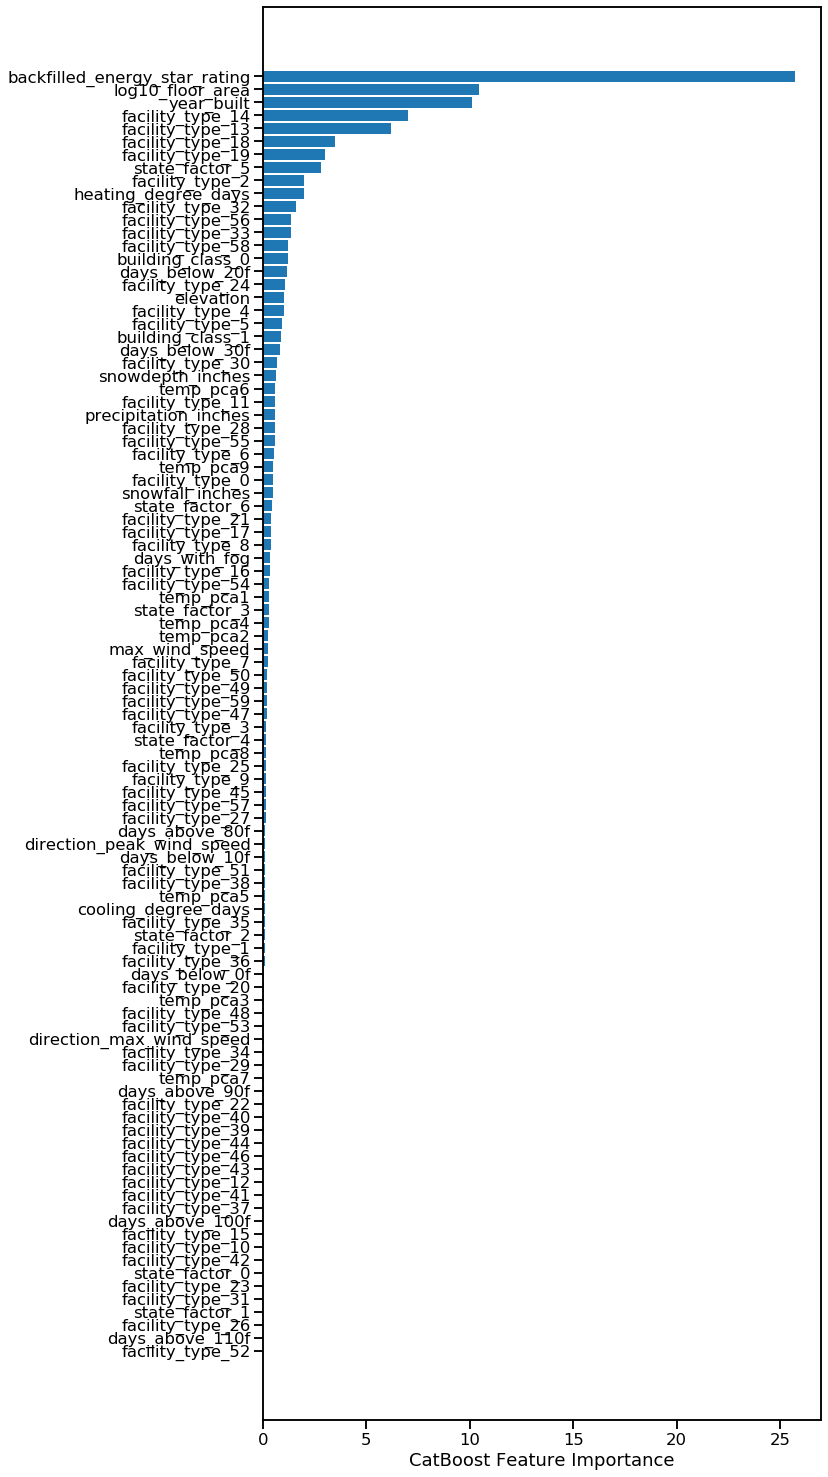

In [9]:
plot_catboost_feature_importance(model)
plt.savefig(f"{wids_path}/validation_result/{config_name}_feature_importance.png")

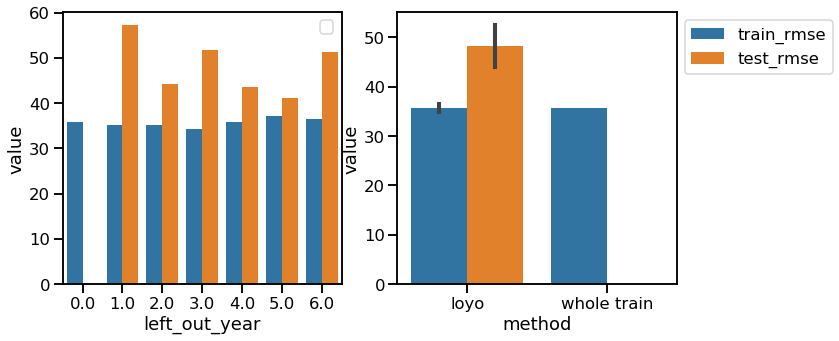

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
sns.barplot(data=pd.melt(catboost_rmse, id_vars=['left_out_year', 'method']), 
                 x='left_out_year', y='value', hue='variable', ax = axes[0])
axes[0].legend([])
sns.barplot(data=pd.melt(catboost_rmse, id_vars=['left_out_year', 'method']), 
            x='method', y='value', hue='variable', ax=axes[1])
axes[1].legend(bbox_to_anchor=(1,1))
plt.savefig(f"{wids_path}/validation_result/{config_name}_rmse_summary.png")

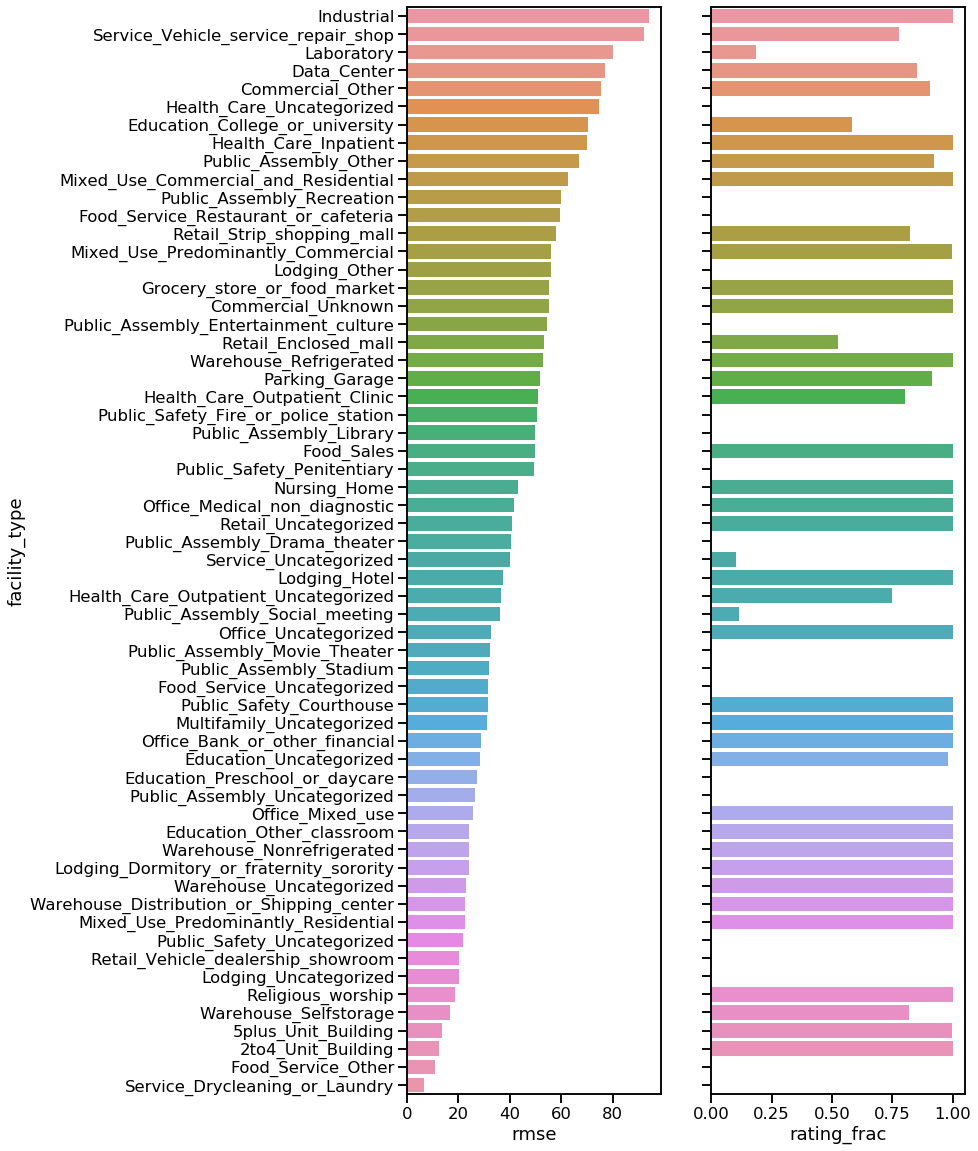

In [11]:
rmse_df = get_rmse_by_group(train_filter_x_df.rename(columns={"backfilled_energy_star_rating": "energy_star_rating"}), train_filter_y_df, train_predict)
plot_rmse_by_group(rmse_df)
plt.savefig(f"{wids_path}/validation_result/{config_name}_rmse_by_group.png")

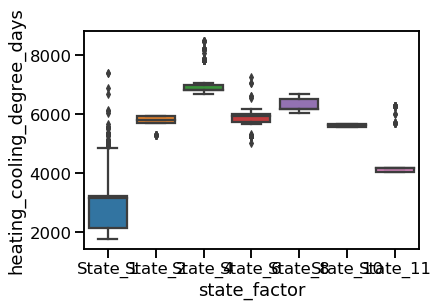

In [14]:
train_filter_df['heating_cooling_degree_days'] = train_filter_df['heating_degree_days'] + train_filter_df['cooling_degree_days']
sns.boxplot(data=train_filter_df, x='state_factor', y='heating_cooling_degree_days')

/Users/diana/anaconda/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:1213: UserWarning: No contour levels were found within the data range.
  **contour_kws,


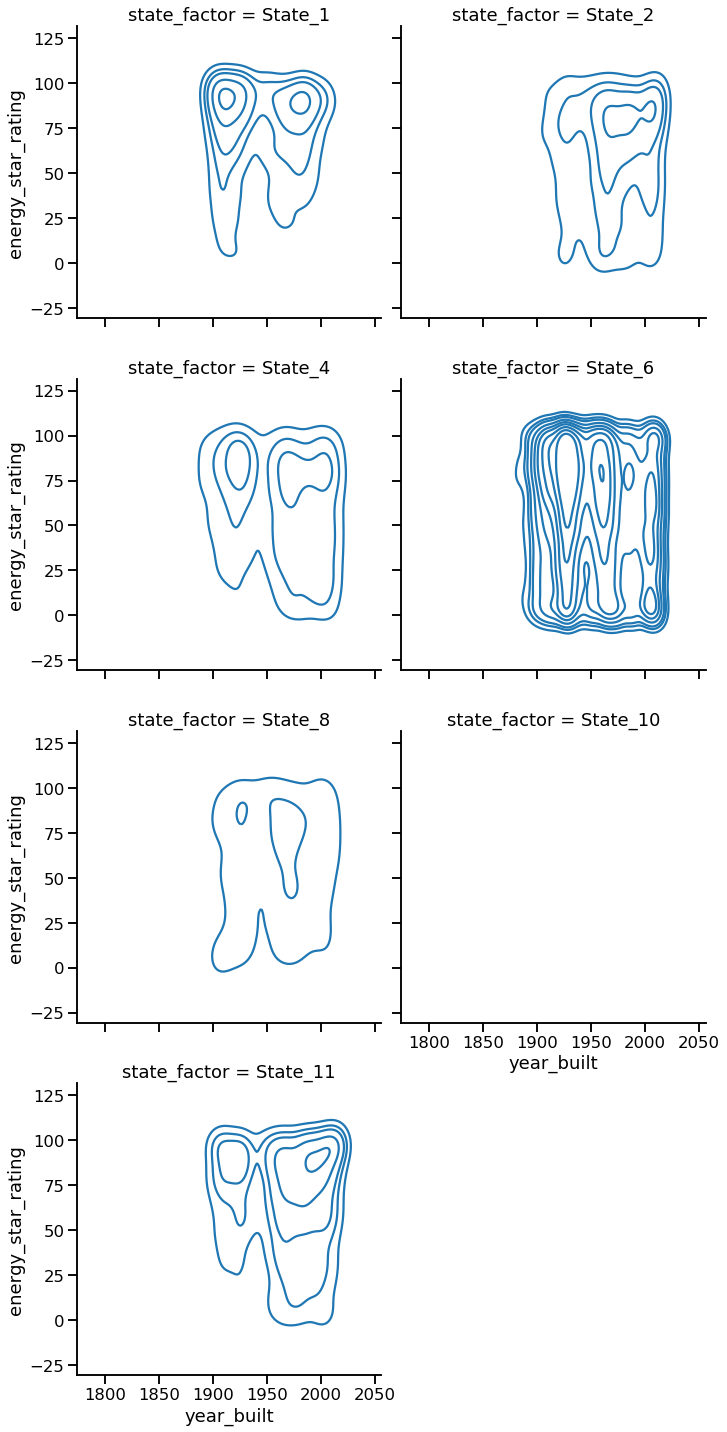

In [40]:
sns.displot(data=train_df.query("year_built>1800"), x='year_built', y='energy_star_rating', col='state_factor',
            col_wrap=2, kind='kde')

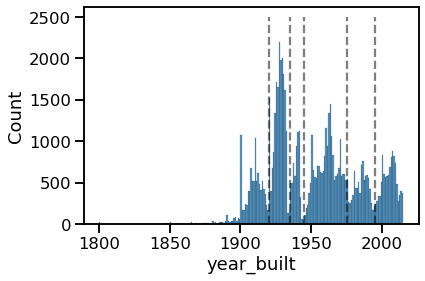

In [31]:
ax = sns.histplot(train_filter_df['year_built'], binwidth=1)
year_built_bins = [1920, 1935, 1945, 1975, 1995]
ax.vlines(year_built_bins, ymin=0, ymax=2500, linestyles='--', alpha=0.5)

# norm = plt.Normalize(train_filter_df['site_eui'].min(), train_filter_df['site_eui'].max())
# sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
# sm.set_array([])

# # Remove the legend and add a colorbar
# ax.get_legend().remove()
# ax.figure.colorbar(sm)

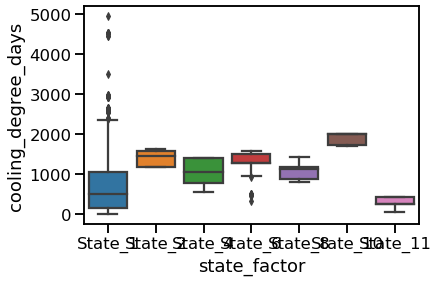

In [12]:
sns.boxplot(data=train_filter_df, x='state_factor', y='cooling_degree_days')

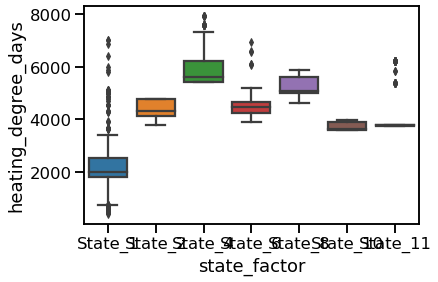

In [13]:
sns.boxplot(data=train_filter_df, x='state_factor', y='heating_degree_days')

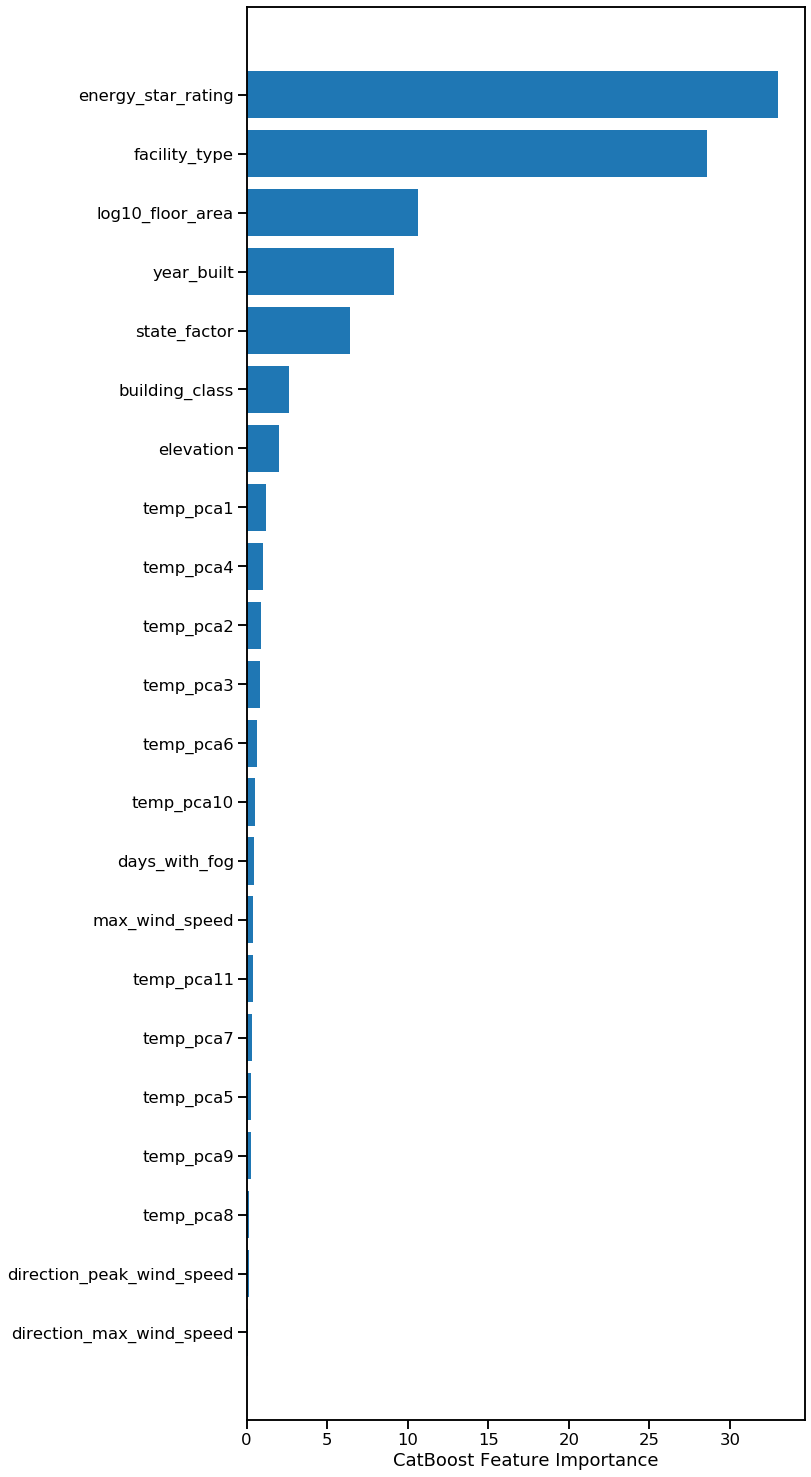

In [8]:
plot_catboost_feature_importance(model)

In [7]:
merged_train_df = combine_features_and_prediction(train_filter_x_df, train_filter_y_df, train_predict)

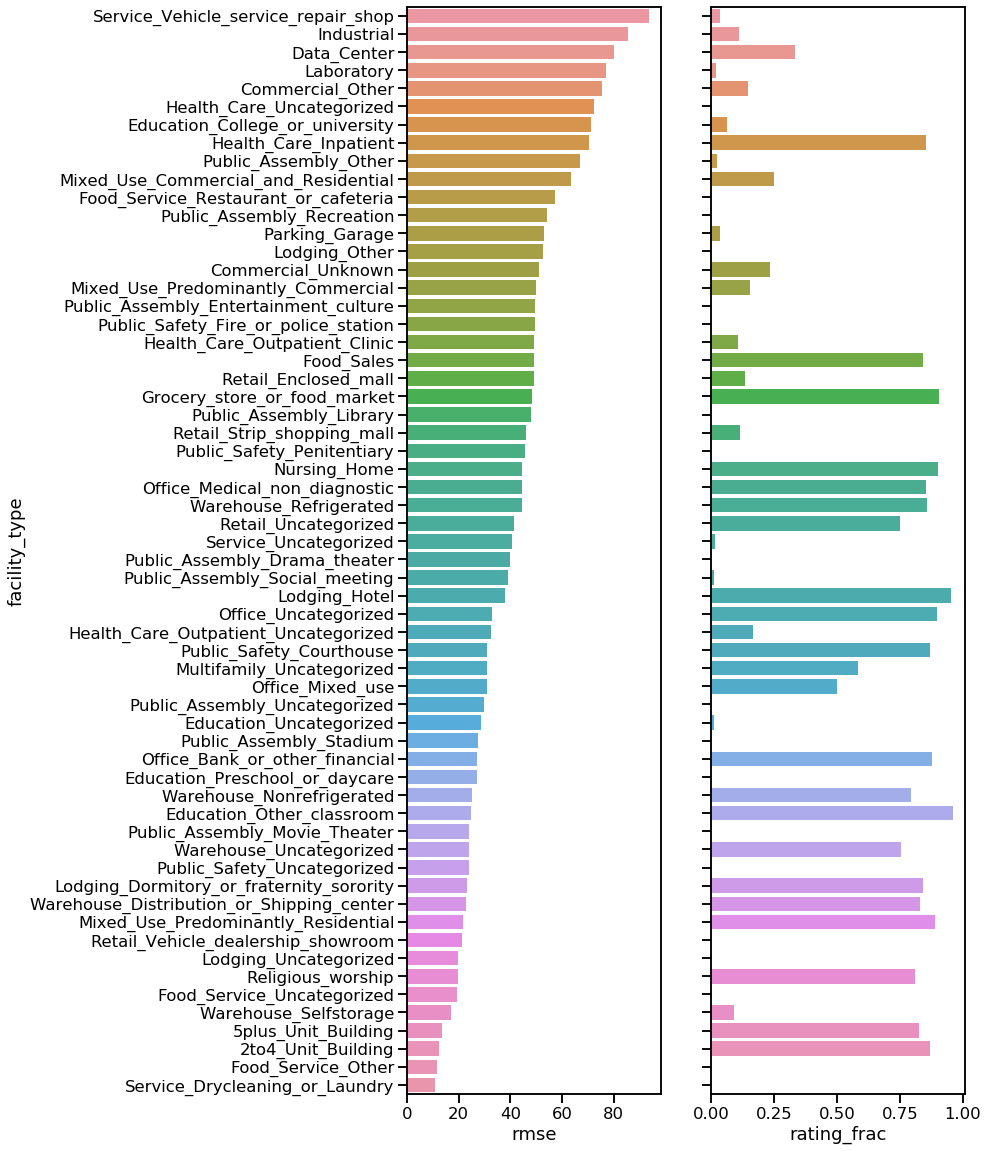

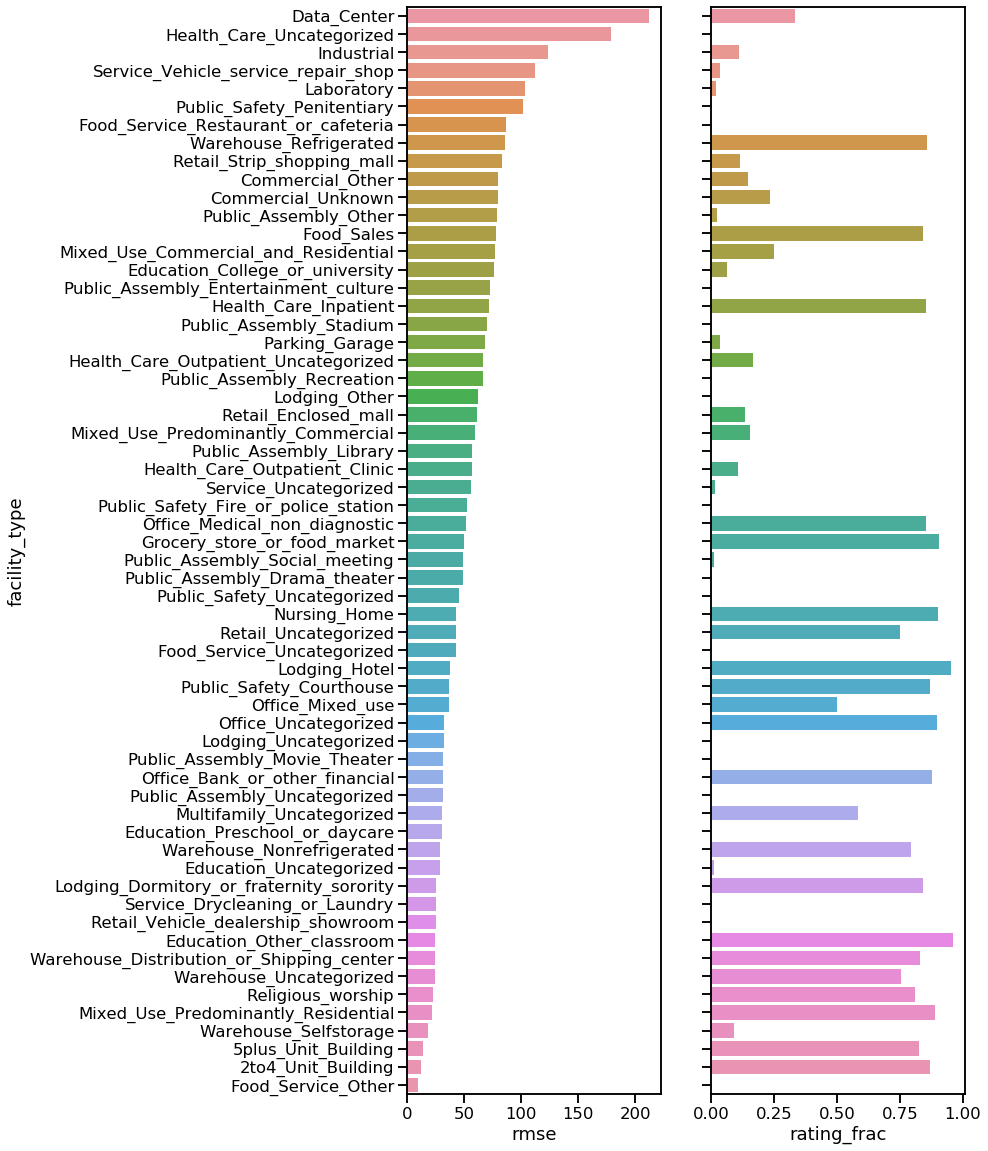

In [10]:
plot_rmse_by_group(rmse_df)

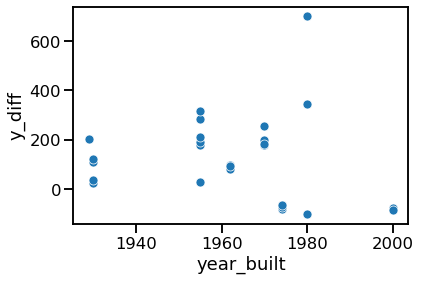

In [16]:
sns.scatterplot(data=merged_train_df.query("facility_type == 'Data_Center'"), x='year_built', y='y_diff')

In [20]:
merged_train_df.query("facility_type == 'Data_Center'")

,days_with_fog,max_wind_speed,year_built,energy_star_rating,direction_max_wind_speed,facility_type,direction_peak_wind_speed,state_factor,elevation,building_class,temp_pca1,temp_pca2,temp_pca3,temp_pca4,temp_pca5,temp_pca6,temp_pca7,temp_pca8,temp_pca9,temp_pca10,temp_pca11,log10_floor_area,y_true,y_pred,y_diff
13,NaN,1.0,1955.0,13.0,1.0,Data_Center,1.0,State_1,2.4,Commercial,9.899709,-3.664954,-2.872117,3.225393,-0.140553,-3.029312,0.462378,0.819529,-1.101217,-0.359836,0.923391,5.790140,608.839519,431.258818,177.580701
930,88.0,1.0,1955.0,14.0,1.0,Data_Center,1.0,State_1,2.4,Commercial,7.518657,3.457206,3.574886,3.848093,1.827769,-0.530686,-0.918268,-0.422340,-0.550403,-1.628838,-0.638583,5.790140,616.121303,425.027204,191.094098
1291,NaN,NaN,1955.0,19.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,7.106097,3.361153,3.129690,3.997770,2.140610,1.388952,-0.196029,-0.454147,-0.178477,-1.323137,-0.558002,5.790140,656.063562,445.931537,210.132024
2505,NaN,NaN,1955.0,24.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,10.970392,3.047361,-1.925137,3.131750,-0.112876,-2.462378,-0.800062,-1.030637,-0.534855,1.775066,1.415461,5.790140,752.066575,468.463168,283.603407
3599,NaN,NaN,1955.0,20.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,8.413486,8.410656,4.567929,2.726743,3.824258,0.029617,2.210053,0.568842,-2.781827,-2.069750,-1.260825,5.790140,775.608943,459.798062,315.810881
4195,NaN,NaN,2000.0,NaN,NaN,Data_Center,NaN,State_1,9.1,Commercial,8.413486,8.410656,4.567929,2.726743,3.824258,0.029617,2.210053,0.568842,-2.781827,-2.069750,-1.260825,5.279190,40.395053,114.603068,-74.208015
4640,NaN,NaN,1955.0,1.0,NaN,Data_Center,NaN,State_1,2.4,Commercial,11.556235,-1.967200,-3.681439,3.868389,-0.633642,-3.298225,0.471599,-1.728747,0.185836,1.482774,0.220019,5.790140,524.064208,496.449437,27.614771
5239,NaN,NaN,2000.0,NaN,NaN,Data_Center,NaN,State_1,45.7,Commercial,11.556235,-1.967200,-3.681439,3.868389,-0.633642,-3.298225,0.471599,-1.728747,0.185836,1.482774,0.220019,5.279190,38.594262,121.418366,-82.824104
14842,12.0,1.0,1980.0,99.0,1.0,Data_Center,1.0,State_6,3.4,Commercial,-0.906130,1.185162,-0.191659,-1.535895,-0.678208,1.663895,0.557920,-1.453838,1.681902,-2.113088,0.466441,4.820077,502.542373,157.706680,344.835693
26916,93.0,1.0,1974.0,39.0,1.0,Data_Center,1.0,State_6,25.6,Commercial,-0.353112,0.033485,0.063749,-1.833425,2.561516,-1.113903,-1.056279,0.582233,0.647049,0.624359,-0.541793,6.040877,54.182890,118.480214,-64.297324
